In [1]:
import math
import re
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load("en_core_web_lg")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angela/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/angela/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
cd src

/Users/angela/diversity-colleges/src


In [17]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [18]:
import sys
sys.path.append('src')
import ouraws

In [34]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="duke"
SUBJECT="opinion"
START_YEAR=2010
FINAL_YEAR=2022

In [20]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [21]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [22]:
diversity_pattern = "\b" + "|".join(diversity_lemmas) + "\b"
text = "This is an inclusive and multi-cultural center that focuses on equality and racial justice."
len(re.findall(diversity_pattern, text))

4

In [23]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    '''Clean & prep text (numpy.Series): lowercase, lemmatize, stopword'''
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split() 
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text)) 
                                 for text in text_series])
    return text_series, total_diversity_words

In [ ]:
df.shape

In [29]:
# NOTE: before loading, we need to be in the "collegier" folder

S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [30]:
df.columns

Index(['url', 'body', 'year', 'month'], dtype='object')

In [31]:
df["year"].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010])

In [32]:
df.loc[(df.year==2011) & (df.month==5)]

,url,body,year,month
6650,https://www.dukechronicle.com/article/2011/05/...,\nDurham calling to the Gothic Wonderland:\nSu...,2011,5
6651,https://www.dukechronicle.com/article/2011/05/...,\n@Everyone If you want to keep up with the wo...,2011,5
6652,https://www.dukechronicle.com/article/2011/05/...,\nA federal budgetary decision for fiscal year...,2011,5
6653,https://www.dukechronicle.com/article/2011/05/...,\nThe first thing I did when I returned home f...,2011,5
6654,https://www.dukechronicle.com/article/2011/05/...,"\nOn Sept. 11, 2001, one man managed to strike...",2011,5
6655,https://www.dukechronicle.com/article/2011/05/...,\nAs outgoing Chair of the Board of Trustees D...,2011,5
6656,https://www.dukechronicle.com/article/2011/05/...,\nHis snoring woke me up.\nIt was 4 a.m. in Be...,2011,5
6657,https://www.dukechronicle.com/article/2011/05/...,\nLike anything of substance that aims to cate...,2011,5
6658,https://www.dukechronicle.com/article/2011/05/...,"\nSometimes, Duke students need to chill out.\...",2011,5
6659,https://www.dukechronicle.com/article/2011/05/...,"\nStanding at just about five feet tall, the s...",2011,5


In [35]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]

    clean_df, num_diversity_words = prepText(year_df.body)    
    wv = [nlp(s) for s in clean_df]
        
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2], 
              'norm-2':   cov[3], 
              'norm-inf': cov[4], 
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
              }
    results.append(result)


2010, 755, 1.873124358460137, 0.08305390741158725
2011, 734, 1.9126009590589454, 0.07858705207999814
2012, 756, 1.9402433328020774, 0.08246525669563913
2013, 701, 1.9786354598128781, 0.0796272104665935
2014, 707, 2.007869149835571, 0.08383840149105905
2015, 753, 1.9779899410961972, 0.08068515364246631
2016, 756, 1.9531775213652667, 0.07633353100267712
2017, 659, 1.8995554421871788, 0.0771747565104274
2018, 540, 1.8891559355967085, 0.08260207613919089
2019, 474, 1.8913892515043658, 0.08710500367881611
2020, 368, 1.879072235294149, 0.08031054262793176
2021, 253, 1.8525642820216395, 0.08105174091752047
2022, 276, 1.865140234529436, 0.08592085642160462


In [36]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2010,0.083054,755,1.873124,1.979309,1.719689,1.979309,93,0.123179
2011,0.078587,734,1.912601,2.036280,1.765465,2.036280,194,0.264305
2012,0.082465,756,1.940243,2.046244,1.783774,2.046244,223,0.294974
2013,0.079627,701,1.978635,2.086896,1.821471,2.086896,249,0.355207
2014,0.083838,707,2.007869,2.112850,1.841580,2.112850,183,0.258840
2015,0.080685,753,1.977990,2.060628,1.819603,2.060628,274,0.363878
2016,0.076334,756,1.953178,2.106776,1.808704,2.106776,332,0.439153
2017,0.077175,659,1.899555,2.045916,1.756420,2.045916,240,0.364188
2018,0.082602,540,1.889156,1.976339,1.735852,1.976339,240,0.444444


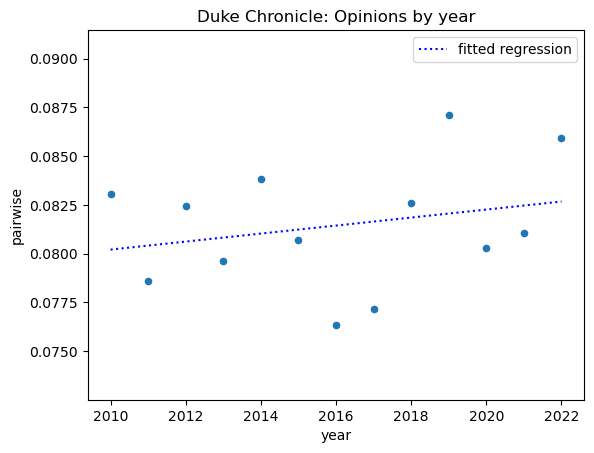

In [40]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Duke Chronicle: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()


mentions-norm slope:0.02813, int:0.21050, r:0.84095, p:0.00032, se:0.00546, x:range(0, 13)
pairwise slope:0.00021, int:0.08021, r:0.25213, p:0.40596, se:0.00024, x:range(0, 13)
trace slope:-0.00643, int:1.95555, r:-0.50438, p:0.07880, se:0.00332, x:range(0, 13)
norm-1 slope:-0.00605, int:2.06602, r:-0.45329, p:0.11979, se:0.00359, x:range(0, 13)
norm-2 slope:-0.00631, int:1.80108, r:-0.52092, p:0.06795, se:0.00312, x:range(0, 13)
norm-inf slope:-0.00605, int:2.06602, r:-0.45329, p:0.11979, se:0.00359, x:range(0, 13)


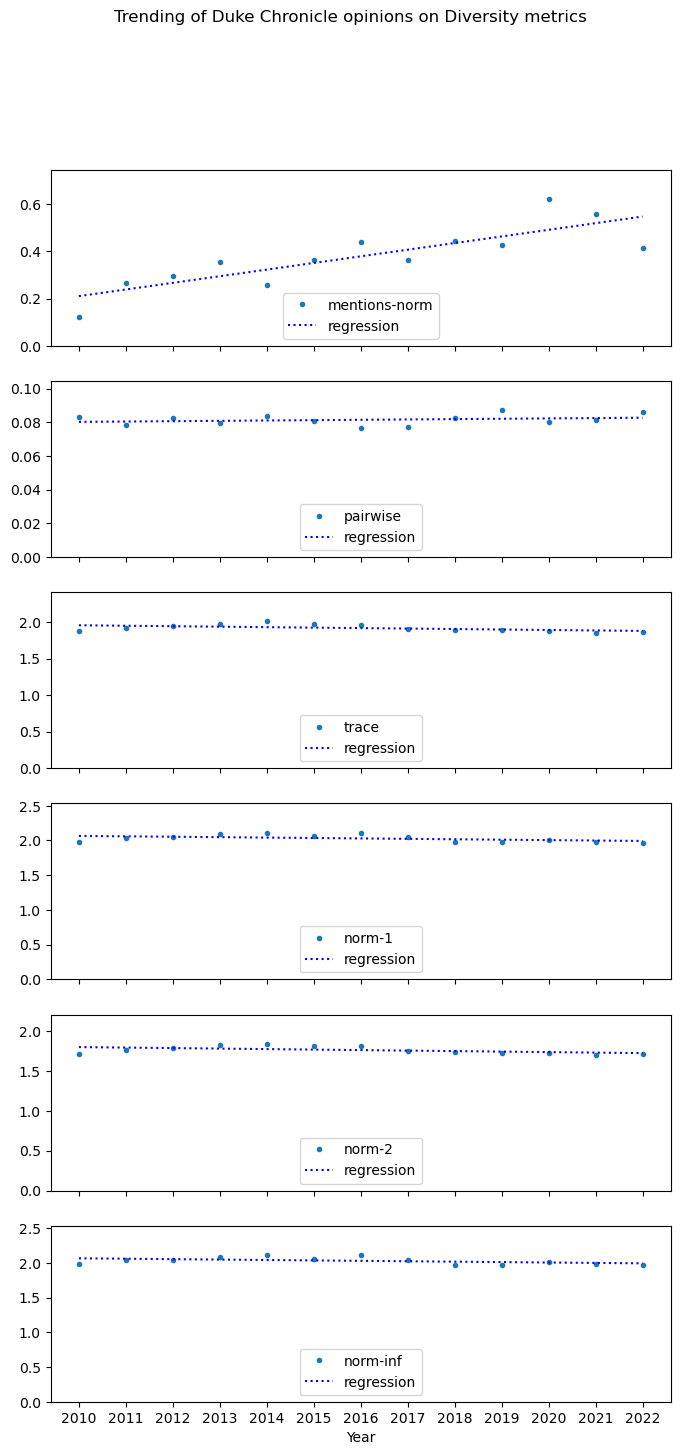

In [41]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(8,16))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Duke Chronicle opinions on Diversity metrics")
plt.show()

mentions-norm slope:0.02813, int:0.21050, r:0.84095, p:0.00032, se:0.00546, x:range(0, 13)
pairwise slope:0.00021, int:0.08021, r:0.25213, p:0.40596, se:0.00024, x:range(0, 13)


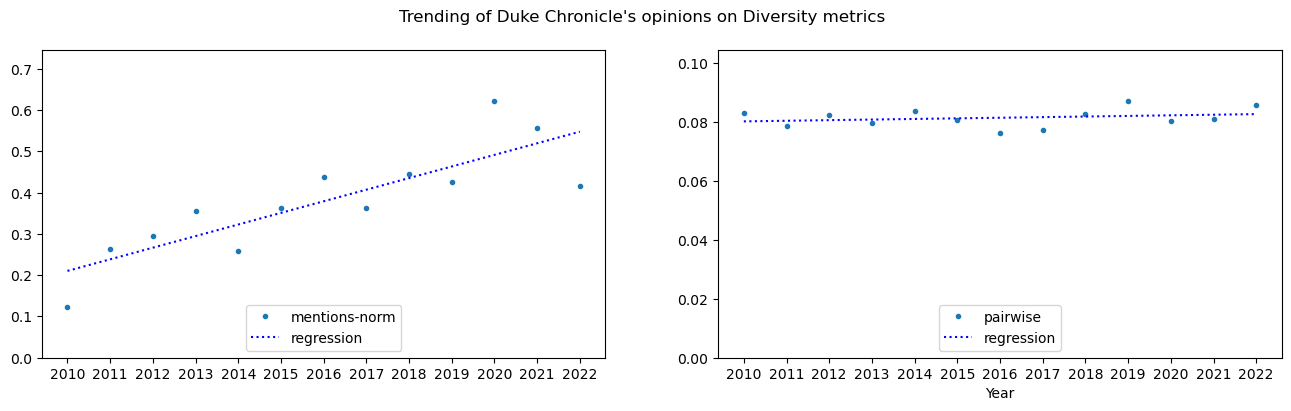

In [42]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Duke Chronicle's opinions on Diversity metrics")
plt.show()